            Objectives

Your challenge is to develop an app or interface that allows a student user to select an exoplanet, uses the information in a star catalog to develop a three-dimensional point cloud (map) of stars corresponding to the perspective of an observer on that exoplanet, and then creates a visualization of this point cloud.

The translated point cloud could be visualized in different ways. Will your app produce a static image of the sky (like the sky charts or guides we have here on Earth), an interactive planetarium (potentially allowing for a virtual reality experience), or something else?

Additional capabilities such as allowing the user to trace and name constellations would help students make each unique exosky their own, enabling a deeper experience and educational opportunity. Your tool could even provide various levels of detail (star name, color, etc.) and make different visual overlays (ecliptic, galactic grid, etc.) available for more advanced uses.

1. Import modules required for application 

In [1]:
import astropy.units as u
import astropy.coordinates
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from astroquery.utils.tap.core import TapPlus
import math
import json
import matplotlib.pyplot as plt

2. Some predefined planet data


In [2]:
p=[['K2-18 b',      38.0266,    62.57509,   254.63265,  172.560141,     7.5878315],
   ['Proxima Cen b',1.30119,    -1.91805,   313.92595,  217.3934657,    -62.6761821],
   ['GJ 667C c',    7.24396,    1.41002,    351.84167,  259.7510609,    -34.9977651],
   ['LHS 1140 b',   14.9861,    -78.05159,  115.40542,  11.2486320,     -15.2741085],
   ['Kepler-186 f', 177.594,    8.17058,    78.51990,   298.6527360,    43.9549884],
   ['Kepler-1229 b',265.482,    10.38018,   80.79418,   297.4868347,    46.9966782],
   ['Kepler-442 b', 365.965,    14.98425,   69.75019,   285.3666029,    39.2800704],
   ['Kepler-62 f',  300.874,    18.69539,   75.03750,   283.2125621,    45.3496992]]

In [3]:
num = 6

3. Set limits for search
We set limits for query in GAIA database by distance (in parsec) and Grvs Magnitude

In [4]:
cube_size = 2000000
min_mag = 6

4. Transform galactical coordinates of exoplanet into cartesian (it's required for coordinates offset of stars)

In [5]:
planet_cartesian = astropy.coordinates.spherical_to_cartesian(p[num][1]*u.parsec,math.radians(p[num][2]),math.radians(p[num][3]))
print(p[num][1]*u.parsec,math.radians(p[num][2]),math.radians(p[num][3]),planet_cartesian)

365.965 pc 0.2615244984419603 1.2173704693916236 (<Quantity 122.3585721 pc>, <Quantity 331.6708096 pc>, <Quantity 94.62153624 pc>)


5. Getting data from GAIA database
We getting such columns as:
designation
distance_gspphot
b
l
grvs_mag
phot_g_mean_mag
phot_bp_mean_mag
phot_rp_mean_mag
This data also dumped into JSON file for future use.

In [6]:
job = Gaia.launch_job_async(f'select designation,distance_gspphot,b,l,grvs_mag,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag '
                            'from gaiadr3.gaia_source '
                            f'where grvs_mag<{min_mag} and distance_gspphot<{cube_size}'
                            ,dump_to_file=True,output_format='json'
                            )
r = job.get_results()       #result from database
print(r)

        designation          distance_gspphot          b          ... phot_g_mean_mag phot_bp_mean_mag phot_rp_mean_mag
                                    pc                deg         ...       mag             mag              mag       
---------------------------- ---------------- ------------------- ... --------------- ---------------- ----------------
Gaia DR3 2059372363884259072          43.0362  3.3646825203147457 ...       3.6234016        4.1796846        2.9626186
Gaia DR3 5263150888430619904          45.1172  -22.15488880640578 ...       3.6618443         4.234168        2.9842567
Gaia DR3 4570796456599587200         131.0198  28.444029687633762 ...       3.9097338        4.6662755        3.0780778
Gaia DR3 2891816671700460288          56.1329  -20.24432138527104 ...       3.6113985        4.0907116        2.9981956
Gaia DR3 5290818758516639104         361.5596  -15.60942822136466 ...       4.2988462         5.441817        3.2379386
Gaia DR3 4757601523650165120          32

6. Transformation of coordinates

Galactical coordinates of stars converted to cartesian. Then we make offset by cartesian coordinates of exoplanet and perform transformation into galactical coordinates.
Calculate size of stars for rendering image

In [11]:
#star_cartesian = result from database in cartesian coordinates (cartesian coordinates of stars for Sun)
#star_cartesian_new = cartesian coordinates of stars for planet (galactical)
star_spherical = []               #spherical coordinates of stars for planet (galactical)
theta=[]
theta_b=[]
radius=[]
radius_b=[]
distance=[]
area=[]
area_b=[]
size1 = 1000 #size of star of magnitude=1
print(planet_cartesian)
for i in range(0,len(r)):
    star_cartesian = astropy.coordinates.spherical_to_cartesian(r[i]['distance_gspphot']*u.parsec,math.radians(r[i]['b']),math.radians(r[i]['l']))
    star_cartesian_new = ([star_cartesian[0]-planet_cartesian[0],star_cartesian[1]-planet_cartesian[1],star_cartesian[2]-planet_cartesian[2]]) 
    star_spherical.append(astropy.coordinates.cartesian_to_spherical(star_cartesian_new[0]*u.parsec,star_cartesian_new[1]*u.parsec,star_cartesian_new[2]*u.parsec))
    #print(r[i]['distance_gspphot']*u.parsec,math.radians(r[i]['b']),math.radians(r[i]['l']),star_spherical)
    #print(star_cartesian,star_cartesian_new)
    distance.append(star_spherical[i][0].value)
    #print(r[i][5])
    if(star_spherical[i][1].value<0):
        radius_b.append(3.14/2-math.fabs(star_spherical[i][1].value))
        theta_b.append(star_spherical[i][2].value)
        area_b.append(1000/math.pow(2.512,r[i][4]-1))
    else:
        radius.append(3.14/2-star_spherical[i][1].value)
        theta.append(star_spherical[i][2].value)
        area.append(1000/math.pow(2.512,r[i][4]-1))

(<Quantity 122.3585721 pc>, <Quantity 331.6708096 pc>, <Quantity 94.62153624 pc>)


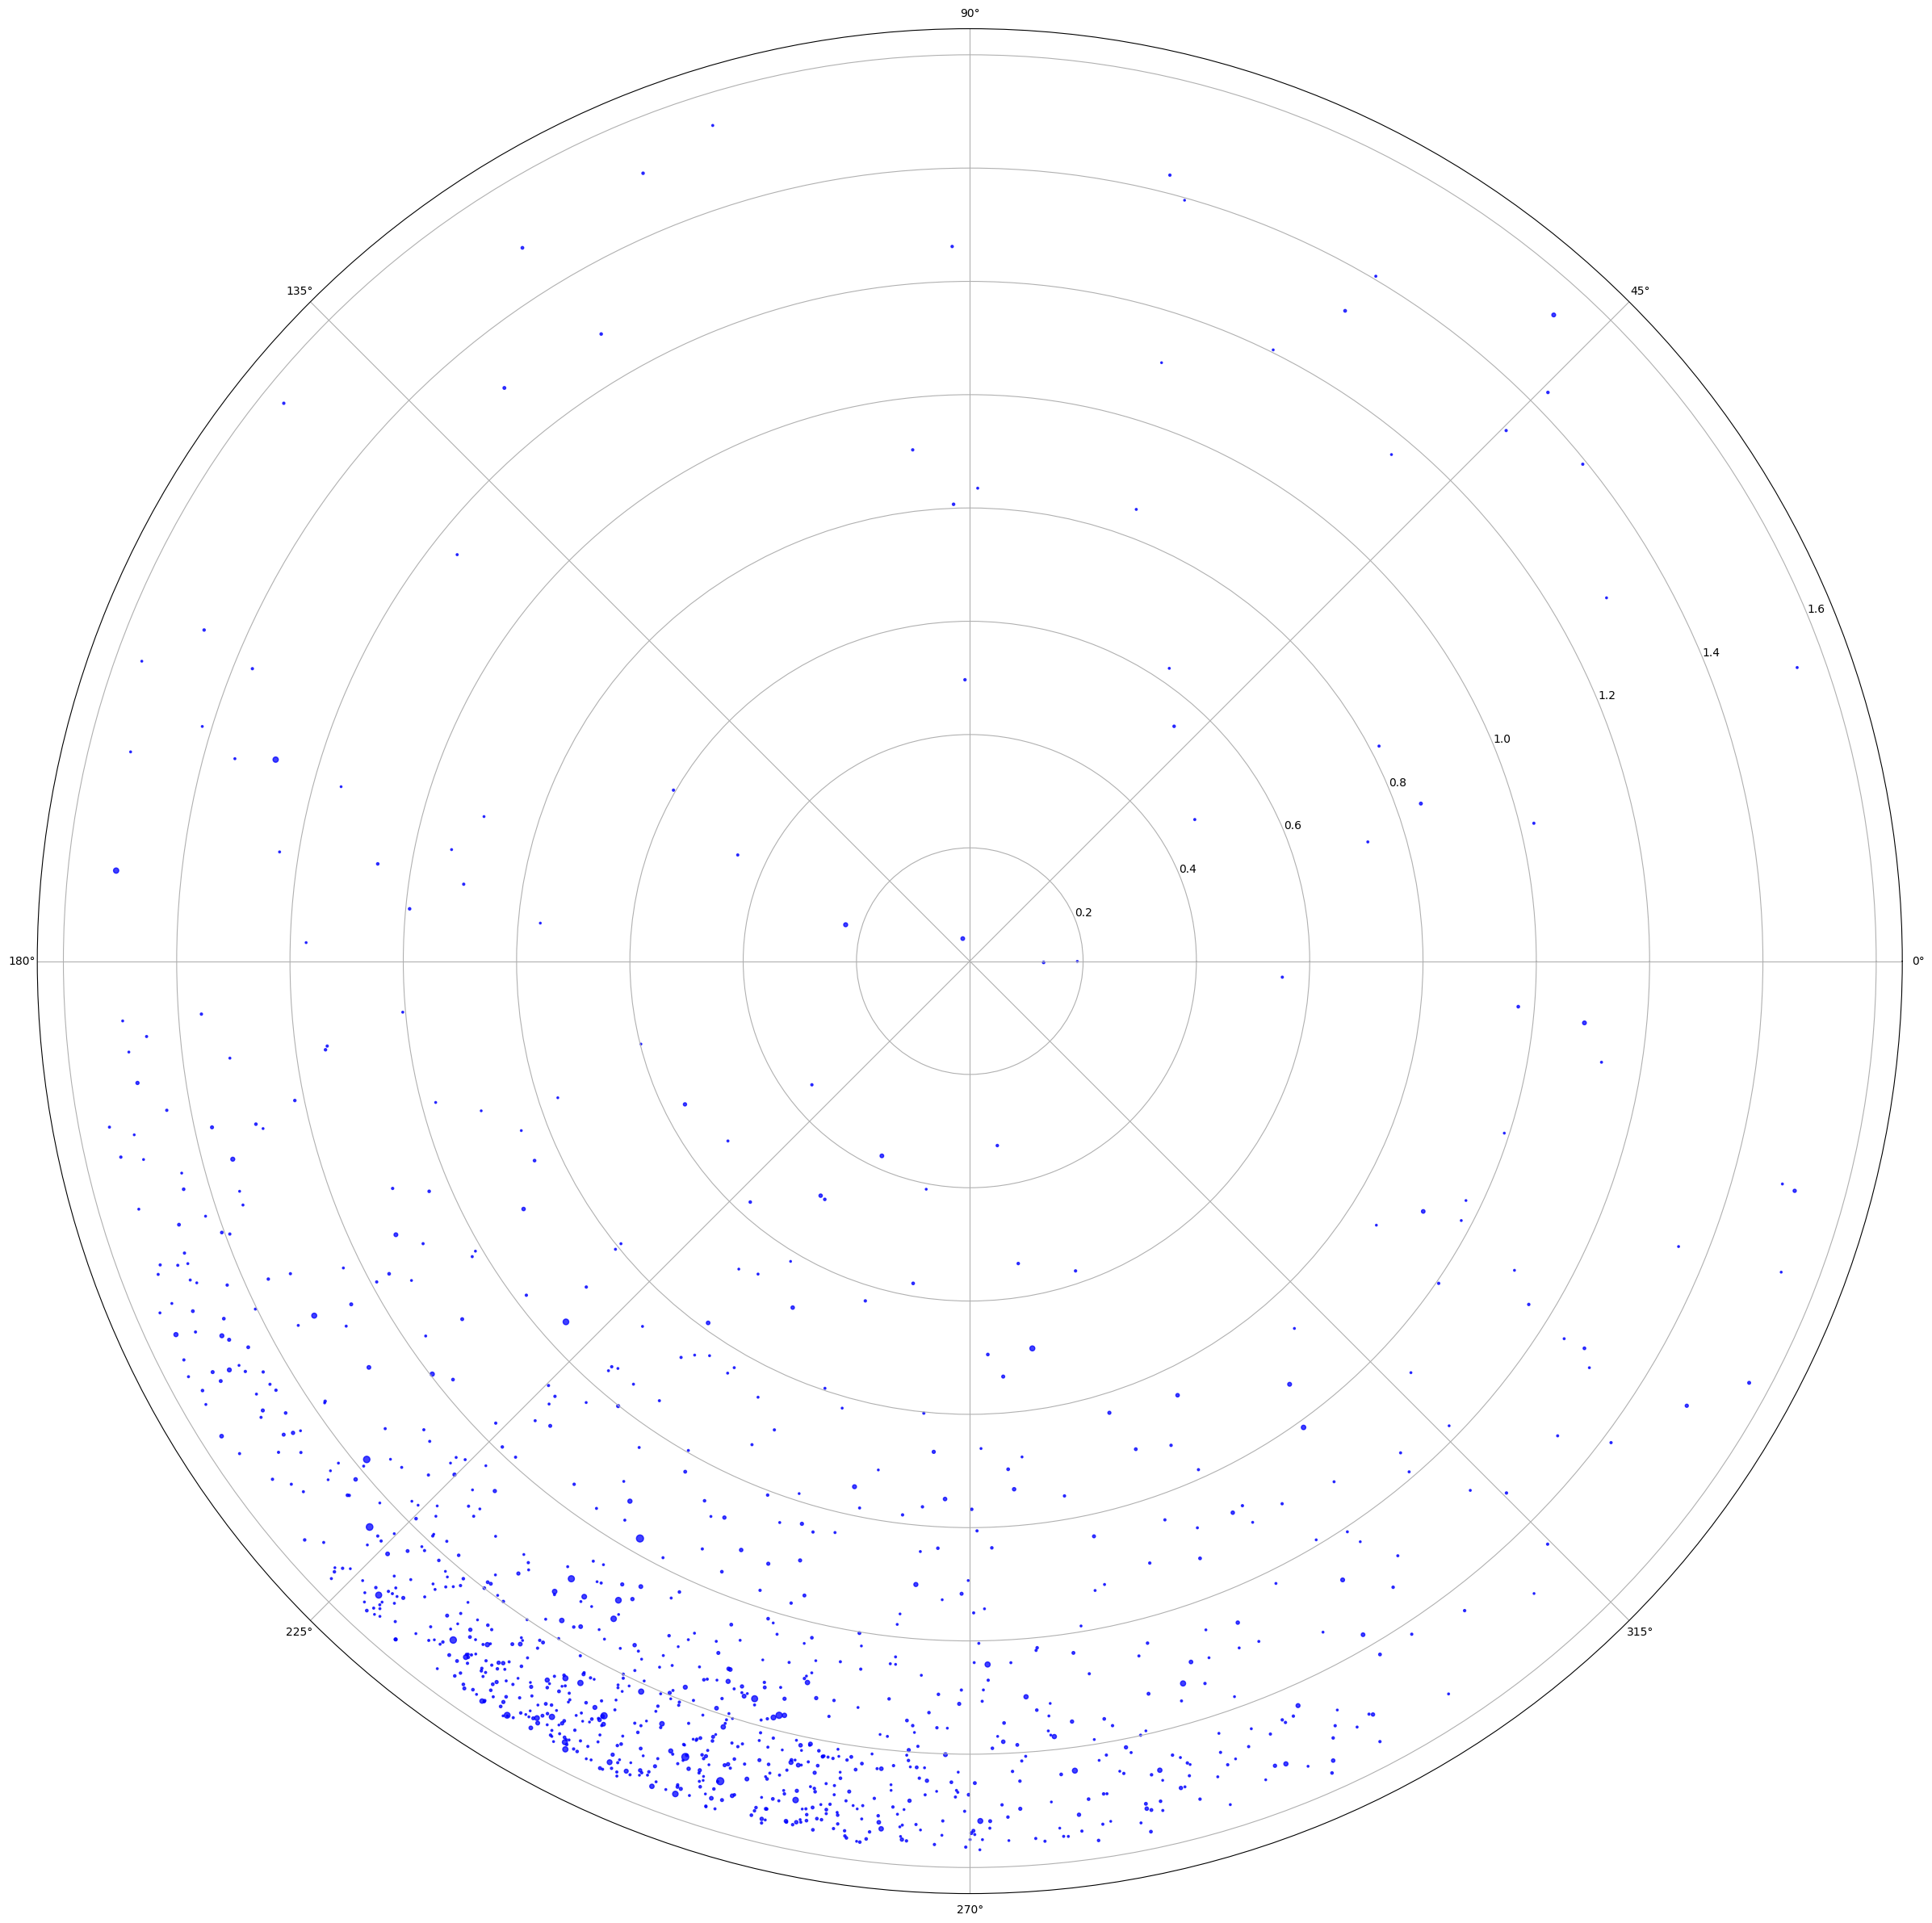

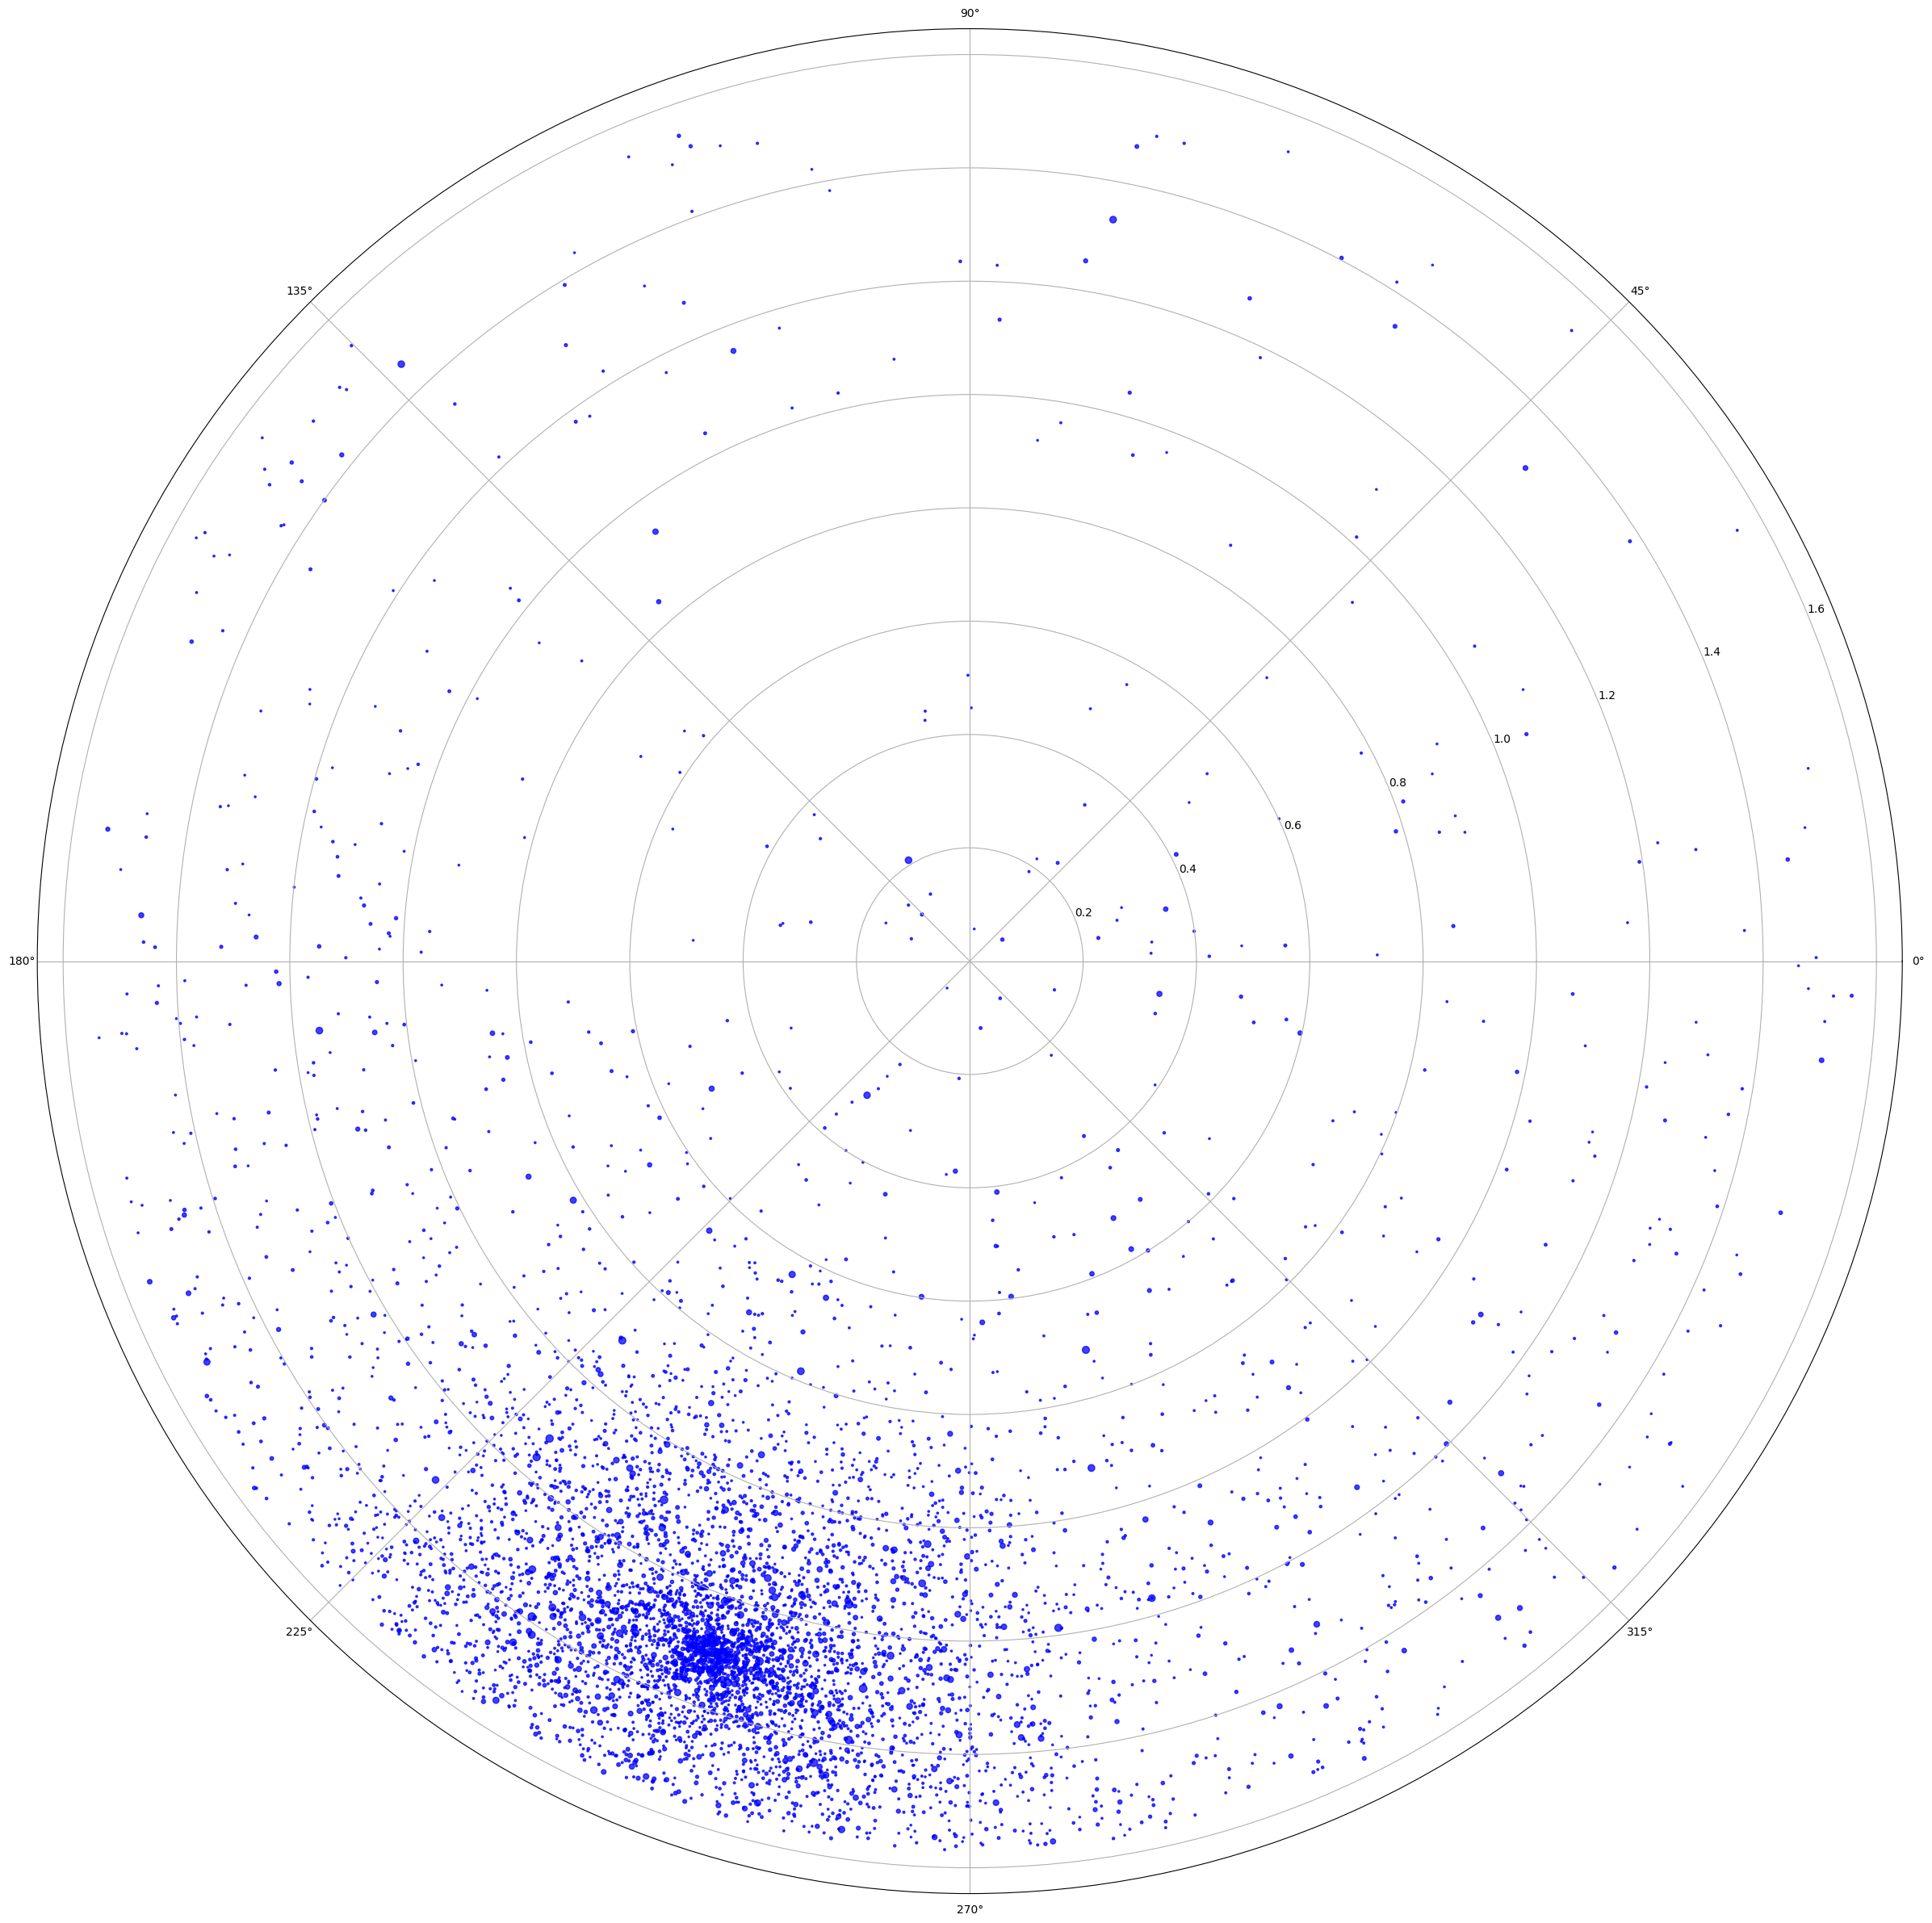

In [12]:
fig1 = plt.figure(figsize=[30,30])
fig2 = plt.figure(figsize=[30,30])
zen = fig1.add_subplot(projection='polar')
nad = fig2.add_subplot(projection='polar')
c = zen.scatter(theta, radius , c='b', s=area, alpha=0.75, marker=".")
c = nad.scatter(theta_b, radius_b , c='b', s=area_b, alpha=0.75, marker=".")
fig1.savefig(str(p[num][0])+' exosky.png',bbox_inches='tight')
fig2.savefig(str(p[num][0])+' exosky_b.png',bbox_inches='tight')
plt.show()